In [ ]:
#@title Install library pendukung
%%capture
!pip install --upgrade plotly
!pip install dataprep

**Import library**
Pada analisis ini saya menggunakan basis data PosgreSQL dan beberapa library lain seperti DataPrep untuk melakukan data cleaning dan Plotly untuk membuat plot dan peta.

In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
from numpy.random import randn
import pandas as pd
import psycopg2 as pg
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from babel.numbers import format_number
from dataprep.clean import clean_country
from scipy import stats
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

NumExpr defaulting to 2 threads.


Sebelum melakukan analisis data tahap pertama adalah membuat koneksi ke server basis data pada server Heroku. Setelah itu proses selanjutnya adalah mengambil data dari tabel orders.

In [ ]:
connectionString = {
    "user":     "evdjeopqhnvikj",
    "password": "c637c3421cb262fc22f71d6dec31c544613560dd85c703bbeaf6053c48af332e",
    "host":     "ec2-54-161-239-198.compute-1.amazonaws.com",
    "port":     5432,
    "dbname":   "d5js0udm4f396v",
}

engine = pg.connect(**connectionString)

**Laporan Jumlah Kargo Dikirim per Periode**
Pada analisis ini akan menampilkan jumlah kargo yang diorder. Pada sel ini dapat dipilih jumlah kargo berdasarkan tanggal pengiriman (shipped date), tanggal pemesanan (order date), dan tenggat waktu (required date).

Selain itu data jumlah kargo dapat diagregasi berdasarkan time series harian, mingguan, bulanan, kuarter, dan tahunan.

In [ ]:
df_orders = pd.read_sql('SELECT * FROM orders', con=engine)
df_order_detail = pd.read_sql("SELECT * FROM order_details", con=engine)

df_order_detail["price_before_discount"] = df_order_detail["unit_price"] * df_order_detail["quantity"]
df_order_detail["price_after_discount"] = df_order_detail["price_before_discount"] * df_order_detail["discount"]
df_order_detail["total_sales"] = df_order_detail["price_before_discount"] - df_order_detail["price_after_discount"]

df_orders["order_date"] = pd.to_datetime(df_orders["order_date"])
df_orders["required_date"] = pd.to_datetime(df_orders["required_date"])
df_orders["shipped_date"] = pd.to_datetime(df_orders["shipped_date"])

order_stats = df_orders.merge(df_order_detail, on="order_id")

In [ ]:
date_index = "shipped_date" #@param ["order_date", "required_date", "shipped_date"]
resample_rule = "M - Monthly" #@param ["B - Daily business days", "W - Weekly", "M - Monthly", "Q - Quarterly", "A - Yearly"]

order_stats_plot = order_stats.copy()
order_stats_plot = order_stats_plot.set_index(date_index)
order_stats_plot = order_stats_plot.resample(resample_rule[0]).sum()

table_cols = ["Periode", "Total Kargo", "Total Penjualan"]
table_rows = [
  order_stats_plot.index,
  order_stats_plot["freight"].apply(lambda x: "{:.2f}".format(x)),
  order_stats_plot["total_sales"].apply(lambda x: "$" + format_number(x))
]

titles=("Total Penjualan", "Detail Penjualan", "Total Kargo")
fig_specs = [
  [{"type": "scatter"}, {"type": "table", "rowspan": 2}],
  [{"type": "scatter"}, {}],
]

fig = make_subplots(rows=2, cols=2, column_widths=[0.7, 0.3], specs=fig_specs, subplot_titles=titles)
fig.add_trace(go.Scatter(x=order_stats_plot.index, y=order_stats_plot["total_sales"],
                         textposition="top center", mode='lines+markers+text'), row=1, col=1)
fig.add_trace(go.Scatter(x=order_stats_plot.index, y=order_stats_plot["freight"],
                         textposition="top center", mode='lines+markers+text'), row=2, col=1)
fig.add_trace(go.Table(header={"values": table_cols}, cells={"values": table_rows}), row=1, col=2)

fig.update_layout(showlegend=False)
fig.show()

**Laporan Total Penjualan Produk**
Pada analisis ini ditampilkan jumlah penjualan produk dan stoknya.

In [ ]:
df_products = pd.read_sql("SELECT product_id, product_name, units_in_stock FROM products", con=engine)
df_order_detail = pd.read_sql("SELECT * FROM order_details", con=engine)

df_order_detail["price_before_discount"] = df_order_detail["unit_price"] * df_order_detail["quantity"]
df_order_detail["price_after_discount"] = df_order_detail["price_before_discount"] * df_order_detail["discount"]
df_order_detail["total_sales"] = df_order_detail["price_before_discount"] - df_order_detail["price_after_discount"]

orders_sums = df_order_detail.groupby("product_id").sum().reset_index()
orders_sums_names = orders_sums.merge(df_products, on="product_id")

In [ ]:
table_cols = ["Nama Barang", "Unit dalam Stok", "Harga per Unit", "Jumlah Order", "Penjualan Kotor", "Total Penjualan (+diskon)"]
table_rows = [
  orders_sums_names["product_name"],
  orders_sums_names["units_in_stock"],
  orders_sums_names["unit_price"].apply(lambda x: "$" + format_number(x)), 
  orders_sums_names["quantity"],
  orders_sums_names["price_before_discount"].apply(lambda x: "$" + format_number(x)),
  orders_sums_names["total_sales"].apply(lambda x: "$" + format_number(x))
]

fig = go.Figure()
fig.add_trace(go.Table(header={"values": table_cols}, cells={"values": table_rows}))
fig.show()

In [ ]:
top_sales =  10#@param {type:"number"}
ascending_order = False #@param {type:"boolean"}
sort_by = "total_sales" #@param ["product_name", "total_sales", "quantity", "units_in_stock"]

orders_filtered = orders_sums_names.sort_values(by=sort_by, ascending=ascending_order)[:top_sales]

series = [
  orders_filtered["product_name"],
  orders_filtered["total_sales"],
  orders_filtered["quantity"],
  orders_filtered["units_in_stock"]
]

fig = go.Figure().set_subplots(1, 3, subplot_titles=("Penjualan", "Barang Dijual", "Barang dalam Stok"))
fig.add_trace(go.Bar(x=series[0], y=series[1], text=series[1]), row=1, col=1)
fig.add_trace(go.Bar(x=series[0], y=series[2], text=series[2]), row=1, col=2)
fig.add_trace(go.Bar(x=series[0], y=series[3], text=series[3]), row=1, col=3)

fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(yaxis_tickprefix='$', yaxis_tickformat=',.2f', showlegend=False)
fig.show()

**Peta Persebaran Order**
Pada analisis ini ditampilkan data spasial tujuan order.

In [ ]:
df_orders = pd.read_sql('SELECT * FROM orders', con=engine)
df_orders["order_date"] = pd.to_datetime(df_orders["order_date"])
df_orders["required_date"] = pd.to_datetime(df_orders["required_date"])
df_orders["shipped_date"] = pd.to_datetime(df_orders["shipped_date"])

**Peta Persebaran Order berdasarkan Negara**

In [ ]:
orders_contries = df_orders.copy()
orders_contries = orders_contries.groupby("ship_country").count()
orders_contries = orders_contries["order_id"]
orders_contries = orders_contries.reset_index()
orders_contries["ship_country"] = orders_contries["ship_country"].str.replace("UK", "GBR", regex=False)
orders_contries = orders_contries[["ship_country", "order_id"]]
orders_contries = clean_country(orders_contries, 'ship_country', output_format='alpha-3')

Country Cleaning Report:
	19 values cleaned (90.48%)
Result contains 21 (100.0%) values in the correct format and 0 null values (0.0%)


In [ ]:
orders_contries.sort_values(by="order_id", ascending=False).head()

,ship_country,order_id,ship_country_clean
19,USA,122,USA
8,Germany,122,DEU
3,Brazil,83,BRA
7,France,77,FRA
18,GBR,56,GBR


In [ ]:
map_labels = {"ship_country_clean": "Kode negara", "ship_country": "Negara", "order_id": "Banyaknya pesanan"}
fig = px.choropleth(orders_contries,
                    color="order_id",
                    locations="ship_country_clean",
                    hover_data=map_labels.keys(),
                    labels=map_labels)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

**Peta Persebaran Order di USA**

In [ ]:
orders_us_regions = df_orders.copy()
orders_us_regions = orders_us_regions[orders_us_regions["ship_country"] == "USA"]
orders_us_regions = orders_us_regions.groupby("ship_region").count()
orders_us_regions = orders_us_regions.reset_index()
orders_us_regions = orders_us_regions[["order_id", "ship_region", "ship_city"]]

In [ ]:
orders_us_regions

,order_id,ship_region,ship_city
0,10,AK,10
1,4,CA,4
2,31,ID,31
3,3,MT,3
4,18,NM,18
5,28,OR,28
6,19,WA,19
7,9,WY,9


In [ ]:
map_labels = {"ship_region": "Kode kota", "ship_city": "Kota", "order_id": "Banyaknya pesanan"}
fig = px.choropleth(orders_us_regions,
                    locationmode="USA-states",
                    scope="usa",
                    color="order_id",
                    locations="ship_region",
                    hover_data=map_labels.keys(),
                    labels=map_labels)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Bivariate Analysis

In [ ]:
df_orders = pd.read_sql('SELECT * FROM orders', con=engine)
df_order_detail = pd.read_sql("SELECT * FROM order_details", con=engine)

df_order_detail["price_before_discount"] = df_order_detail["unit_price"] * df_order_detail["quantity"]
df_order_detail["price_after_discount"] = df_order_detail["price_before_discount"] * df_order_detail["discount"]
df_order_detail["total_sales"] = df_order_detail["price_before_discount"] - df_order_detail["price_after_discount"]

df_orders["order_date"] = pd.to_datetime(df_orders["order_date"])
df_orders["required_date"] = pd.to_datetime(df_orders["required_date"])
df_orders["shipped_date"] = pd.to_datetime(df_orders["shipped_date"])

order_stats = df_orders.merge(df_order_detail, on="order_id")

In [ ]:
date_index = "shipped_date" #@param ["order_date", "required_date", "shipped_date"]
resample_rule = "M - Monthly" #@param ["B - Daily business days", "W - Weekly", "M - Monthly", "Q - Quarterly", "A - Yearly"]

order_stats_plot = order_stats.copy()
order_stats_plot = order_stats_plot.set_index(date_index)
order_stats_plot = order_stats_plot.resample(resample_rule[0]).sum()

table_cols = ["Periode", "Total Kargo", "Total Penjualan"]
table_rows = [
  order_stats_plot.index,
  order_stats_plot["freight"].apply(lambda x: "{:.2f}".format(x)),
  order_stats_plot["total_sales"].apply(lambda x: "$" + format_number(x))
]

titles=("Total Penjualan", "Detail Penjualan", "Total Kargo")
fig_specs = [
  [{"type": "scatter"}, {"type": "table", "rowspan": 2}],
  [{"type": "scatter"}, {}],
]

fig = make_subplots(rows=2, cols=2, column_widths=[0.7, 0.3], specs=fig_specs, subplot_titles=titles)
fig.add_trace(go.Scatter(x=order_stats_plot.index, y=order_stats_plot["total_sales"],
                         textposition="top center", mode='lines+markers+text'), row=1, col=1)
fig.add_trace(go.Scatter(x=order_stats_plot.index, y=order_stats_plot["freight"],
                         textposition="top center", mode='lines+markers+text'), row=2, col=1)
fig.add_trace(go.Table(header={"values": table_cols}, cells={"values": table_rows}), row=1, col=2)

fig.update_layout(showlegend=False)
fig.show()

Multivariate Analysis

In [ ]:
df_products = pd.read_sql("SELECT product_id, product_name, units_in_stock FROM products", con=engine)
df_order_detail = pd.read_sql("SELECT * FROM order_details", con=engine)
 
df_order_detail["price_before_discount"] = df_order_detail["unit_price"] * df_order_detail["quantity"]
df_order_detail["price_after_discount"] = df_order_detail["price_before_discount"] * df_order_detail["discount"]
df_order_detail["total_sales"] = df_order_detail["price_before_discount"] - df_order_detail["price_after_discount"]
 
orders_sums = df_order_detail.groupby("product_id").sum().reset_index()
orders_sums_names = orders_sums.merge(df_products, on="product_id")

In [ ]:
top_sales =  10#@param {type:"number"}
ascending_order = False #@param {type:"boolean"}
sort_by = "total_sales" #@param ["product_name", "total_sales", "quantity", "units_in_stock"]

orders_filtered = orders_sums_names.sort_values(by=sort_by, ascending=ascending_order)[:top_sales]

series = [
  orders_filtered["product_name"],
  orders_filtered["total_sales"],
  orders_filtered["quantity"],
  orders_filtered["units_in_stock"]
]

fig = go.Figure().set_subplots(1, 3, subplot_titles=("Penjualan", "Barang Dijual", "Barang dalam Stok"))
fig.add_trace(go.Bar(x=series[0], y=series[1], text=series[1]), row=1, col=1)
fig.add_trace(go.Bar(x=series[0], y=series[2], text=series[2]), row=1, col=2)
fig.add_trace(go.Bar(x=series[0], y=series[3], text=series[3]), row=1, col=3)

fig.update_traces(texttemplate='%{text:.2s}', textposition='outside')
fig.update_layout(yaxis_tickprefix='$', yaxis_tickformat=',.2f', showlegend=False)
fig.show()

Univariate Analysis

In [ ]:
df_orders = pd.read_sql('SELECT * FROM orders', con=engine)
df_products = pd.read_sql("SELECT * FROM products", con=engine)

In [ ]:
#checking rowsXcolumns
df_orders.shape

(830, 14)

In [ ]:
#checking rowsXcolumns
df_products.shape

(77, 10)

In [ ]:
#checking first five records
df_orders.head()

,order_id,customer_id,employee_id,order_date,required_date,shipped_date,ship_via,freight,ship_name,ship_address,ship_city,ship_region,ship_postal_code,ship_country
0,10248,VINET,5,1996-07-04,1996-08-01,1996-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,None,51100,France
1,10249,TOMSP,6,1996-07-05,1996-08-16,1996-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,None,44087,Germany
2,10250,HANAR,4,1996-07-08,1996-08-05,1996-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,RJ,05454-876,Brazil
3,10251,VICTE,3,1996-07-08,1996-08-05,1996-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,None,69004,France
4,10252,SUPRD,4,1996-07-09,1996-08-06,1996-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,None,B-6000,Belgium


In [ ]:
#checking first five records
df_products.head()

,product_id,product_name,supplier_id,category_id,quantity_per_unit,unit_price,units_in_stock,units_on_order,reorder_level,discontinued
0,1,Chai,8,1,10 boxes x 30 bags,18.00,39,0,10,1
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,1
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1


In [ ]:
#mean, median, mode, min, max, and quantiles
df_orders.describe()

,order_id,employee_id,ship_via,freight
count,830.000000,830.000000,830.000000,830.000000
mean,10662.500000,4.403614,2.007229,78.244205
std,239.744656,2.499648,0.779685,116.779294
min,10248.000000,1.000000,1.000000,0.020000
25%,10455.250000,2.000000,1.000000,13.380000
50%,10662.500000,4.000000,2.000000,41.360000
75%,10869.750000,7.000000,3.000000,91.430000
max,11077.000000,9.000000,3.000000,1007.640000


In [ ]:
#mean, median, mode, min, max, and quantiles
df_products.describe()

,product_id,supplier_id,category_id,unit_price,units_in_stock,units_on_order,reorder_level,discontinued
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,39.000000,13.740260,4.116883,28.833896,40.506494,10.129870,12.467532,0.129870
std,22.371857,8.116589,2.395028,33.829311,36.147222,23.141072,10.931105,0.338365
min,1.000000,1.000000,1.000000,2.500000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,7.000000,2.000000,13.000000,15.000000,0.000000,0.000000,0.000000
50%,39.000000,13.000000,4.000000,19.500000,26.000000,0.000000,10.000000,0.000000
75%,58.000000,20.000000,6.000000,33.250000,61.000000,0.000000,25.000000,0.000000
max,77.000000,29.000000,8.000000,263.500000,125.000000,100.000000,30.000000,1.000000


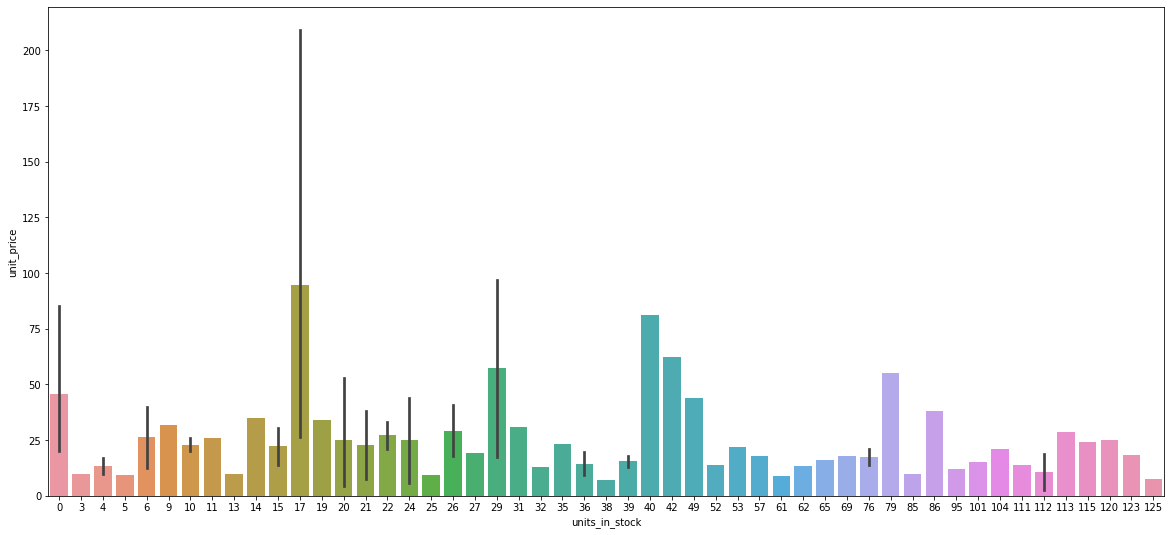

In [ ]:
#bar plot
fig_dims = (20, 9)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x="units_in_stock",y="unit_price",data=df_products)